In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


In [108]:
import matplotlib.pyplot as plt
from tensorflow import keras

import copy
import cv2
from PIL import Image

In [109]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터 불러오기

In [3]:
import tensorflow_datasets as tfds

In [27]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

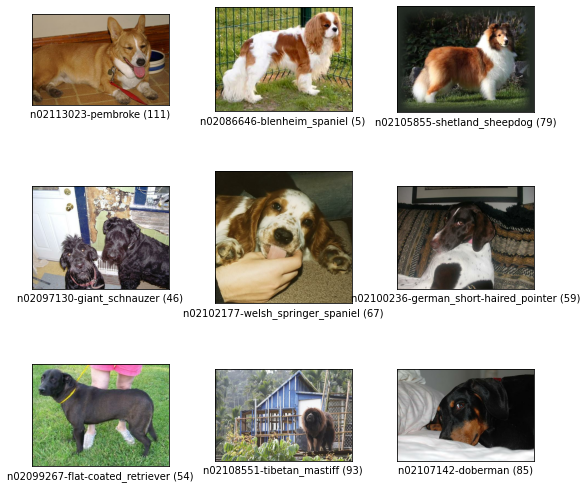

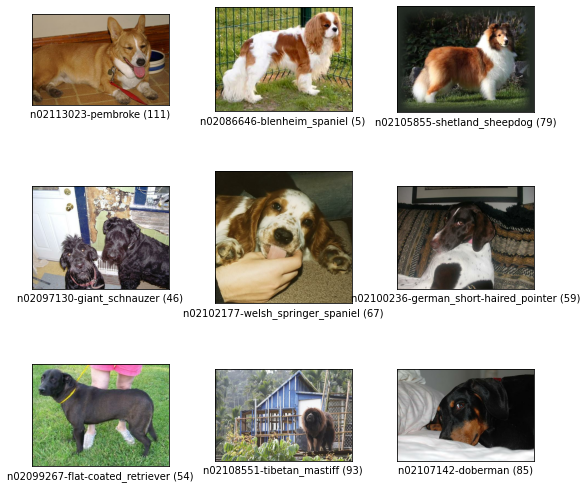

In [28]:
tfds.show_examples(ds_train, ds_info)

In [29]:
data_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## 프로젝트 목표
1. CAM, Grad-CAM 구현하기
2. 구현된 CAM 과 Grad-CAM으로 OpenCV를 사용하여 시각화하기
3. Grad-CAM으로 얻은 CAM을 통해 bounding box 구하고 시각화하기
4. Ground truth 와 prediction box를 이용해 IoU를 계산하는 함수 만들기
5. CAM 과 Grad-CAM으로 얻은 bounding box와 ground truth bounding box와의 IoU 비교하기

## 1. CAM, Grad-CAM 구현하기

#### CAM을 얻기 위한 기본 모델 구성과 학습

In [55]:
num_classes = data_info.features["label"].num_classes

base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)

## GAP 된 출력값을 저장
x = base_model.output

## 분류기 층을 쌓는다. 
preds = keras.layers.Dense(num_classes, activation="softmax")(x)

## 모델 생성
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [56]:
cam_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

**ResNet50 뒤쪽 부분에 `conv5_block3_out`에서 feature map들이 `GlobalAveragePooling2`를 통해 벡터 형태로 변환된 것을 확인할 수 있다. 또한 뒤에 `Dense`를 통해 분류기를 추가했다.**

In [57]:
## 정규화 및 사이즈 조정
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [58]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
train_norm = apply_normalize_on_dataset(ds_train)
val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [59]:
## 모델 complie 및 학습
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 159s 208ms/step - loss: 2.2573 - accuracy: 0.4334 - val_loss: 3.2334 - val_accuracy: 0.2201
Epoch 2/15
750/750 [==============================] - 155s 206ms/step - loss: 0.6451 - accuracy: 0.8308 - val_loss: 1.2967 - val_accuracy: 0.6248
Epoch 3/15
750/750 [==============================] - 155s 207ms/step - loss: 0.1842 - accuracy: 0.9705 - val_loss: 1.0144 - val_accuracy: 0.7021
Epoch 4/15
750/750 [==============================] - 170s 226ms/step - loss: 0.0599 - accuracy: 0.9962 - val_loss: 0.9727 - val_accuracy: 0.7217
Epoch 5/15
750/750 [==============================] - 155s 207ms/step - loss: 0.0285 - accuracy: 0.9992 - val_loss: 0.9493 - val_accuracy: 0.7330
Epoch 6/15
750/750 [==============================] - 155s 206ms/step - loss: 0.0318 - accuracy: 0.9982 - val_loss: 0.9819 - val_accuracy: 0.7273
Epoch 7/15
750/750 [==============================] - 155s 206ms/step - loss: 0.0149 - accuracy: 0.9995 - val_loss: 0.9675 -

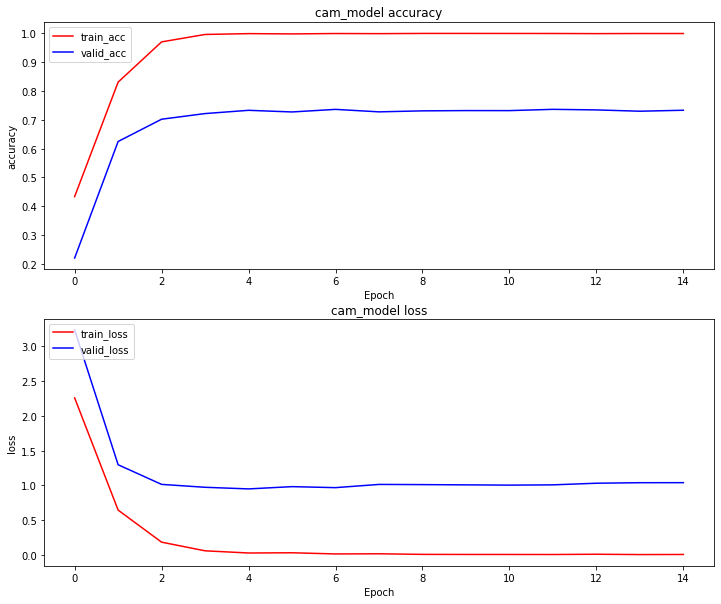

In [63]:
## 모델 결과 시각화
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(history_cam_model.history['accuracy'], 'r', label="train_acc")
plt.plot(history_cam_model.history['val_accuracy'], 'b', label="valid_acc")
plt.title('cam_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(history_cam_model.history['loss'], 'r', label="train_loss")
plt.plot(history_cam_model.history['val_loss'], 'b', label="valid_loss")
plt.title('cam_model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

**train loss와 train acc는 꾸준히 나아지고 있지만, valid loss는 줄어들었다가 조금씩 커지는 경향이 있다. 그러나 valid acc는 valid loss가 커져도 줄어들거나 그대로 유지된다.**

In [64]:
cam_model.save("resnet50_cam_model.h5")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


#### CAM 구현하기

In [115]:
def generate_cam(model, item):
    cam_image = None

    ## 새로운 원본 이미지 복사
    item = copy.deepcopy(item)
    
    ## cam_image를 resize하기 위해 height 와 width 저장
    height, width = item["image"].shape[0], item["image"].shape[1]
    
    ## 이미지 정규화 및 사이즈 변환
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    ## 학습한 모델에서 원하는 Layer의 output을 얻기위해 모델의 input과 output 재정의
    redef_cam_model = tf.keras.models.Model(
        [model.inputs], ## 재정의한 모델의 input
        [model.layers[-3].output] ## 재정의한 모델의 output -> 마지막 conv의 feature map들
    )
    
    ## ?차원을 늘리고 첫번째 부분만 들고온다.?
    last_feature_maps = redef_cam_model(tf.expand_dims(img_tensor, 0))
    last_feature_maps = last_feature_maps[0, :, :, :]
    
    ## 모델의 마지막 layer의 weight 저장
    class_weights = model.layers[-1].get_weights()[0]
    
    ## cam_image를 마지막 layer의 모양과 같은 형태로 0을 채운다. 
    cam_image = np.zeros(dtype=np.float32, shape=last_feature_maps.shape[0:2])
    
    ## 채널 별 feature map에 학습된 가중치를 곱해 모두 더한다. 
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * last_feature_maps[:, :, i]
    
    ## activation score를 정규화한다. 
    cam_image /= np.max(cam_image)
    
    cam_image = cam_image.numpy()
    
    ## cam_image를 원본 이미지의 사이즈로 보간을 통해 변환한다. 
    cam_image = cv2.resize(
        cam_image, 
        (width, height), 
        interpolation=cv2.INTER_CUBIC ## 3차회선 보간법
    )
    
    return cam_image

In [166]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

84


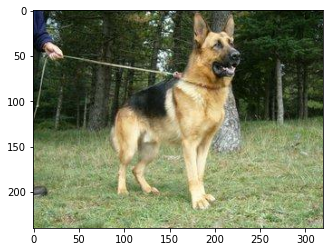

In [230]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

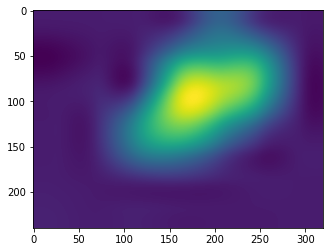

In [231]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

**heatmap에 원본 이미지에서의 강아지 부분만 잘 표현되어있다.** 

#### Grad CAM 구현하기

In [245]:
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None    

    ## 새로운 원본 이미지 복사
    item = copy.deepcopy(item)
    
    ## cam_image를 resize하기 위해 height 와 width 저장
    height, width = item["image"].shape[0], item["image"].shape[1]
    
    ## 이미지 정규화 및 사이즈 변환
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    ## 학습한 모델에서 원하는 Layer의 output을 얻기위해 모델의 input과 output 재정의
    redef_grad_cam_model = tf.keras.models.Model(
        [model.inputs], ## 재정의한 모델의 input
        [model.get_layer(activation_layer).output, model.output] ## 재정의한 모델의 output -> 마지막 conv의 feature map들
    )
    
    ## 기울기를 얻기 위한 코드
    with tf.GradientTape() as tape:
        conv_output, pred = redef_grad_cam_model(tf.expand_dims(img_tensor, 0))
        
        ## 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        loss = pred[:, class_idx]
        
        ## 원하는 layer의 output을 얻습니다.
        output = conv_output[0]
        
        ## 예측값에 따른 Layer의 gradient를 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0]
    
    
    ## gradient의 GAP으로 weight를 구합니다.
    weights = np.mean(grad_val, axis=(0, 1))
    
    ## grad_cam_image를 마지막 layer의 모양과 같은 형태로 0을 채운다. 
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    
    ## 채널 별 output에 학습된 가중치를 곱해 모두 더한다. 
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
    
    
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    
    ## activation score를 정규화한다. 
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    
    ## cam_image를 원본 이미지의 사이즈로 보간을 통해 변환한다. 
    grad_cam_image = cv2.resize(
        grad_cam_image, 
        (width, height), 
        interpolation=cv2.INTER_CUBIC ## 3차회선 보간법
    )
    
    return grad_cam_image

80


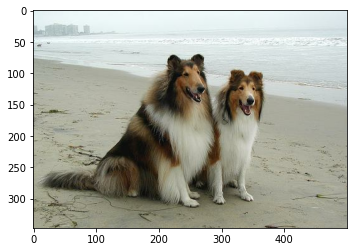

In [247]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

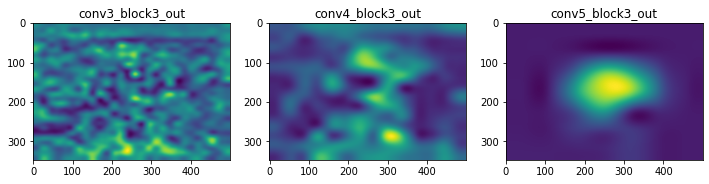

In [251]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
grad_cam_image3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image3)
plt.title("conv3_block3_out")

plt.subplot(1,3,2)
grad_cam_image4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image4)
plt.title("conv4_block3_out")

plt.subplot(1,3,3)
grad_cam_image5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image5)
plt.title("conv5_block3_out")

plt.show()

conv layer마다 다른 곳에 대해 포착하고 있는 것 같다.  
마지막 conv의 경우 cam과 동일하게 강아지들에 집중하고 있다.  

## 2. 구현된 CAM 과 Grad-CAM으로 OpenCV를 사용하여 시각화하기

In [347]:
def visualize_cam_on_image(src1, src2, alpha=0.6):
    cam_colormap = cv2.applyColorMap(src2, cv2.COLORMAP_JET)

    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, cam_colormap, beta, 0.0)
    return merged_image

In [348]:
## Original
item = get_one(ds_test)
## 원본 이미지를 uint8로 변환
origin_image = item['image'].astype(np.uint8)

In [349]:
## CAM
cam_image = generate_cam(cam_model, item)

## CAM 이미지를 3채널로 변환 및 uint8로 변환
cam_image_3channel = np.stack(
    [cam_image*255] * 3, axis=-1
).astype(np.uint8)

## 원본 이미지와 CAM 이미지 합성
blended_image = visualize_cam_on_image(
    origin_image, 
    cam_image_3channel, 
    alpha=0.5
)

In [350]:
## Grad_CAM
## conv3
grad_cam_image3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)

## CAM 이미지를 3채널로 변환 및 uint8로 변환
grad_cam_image3_3channel = np.stack(
    [grad_cam_image3*255] * 3, axis=-1
).astype(np.uint8)

## 원본 이미지와 CAM 이미지 합성
blended_image3 = visualize_cam_on_image(
    origin_image, 
    grad_cam_image3_3channel, 
    alpha=0.5
)

## conv4
grad_cam_image4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
## CAM 이미지를 3채널로 변환 및 uint8로 변환
grad_cam_image4_3channel = np.stack(
    [grad_cam_image4*255] * 3, axis=-1
).astype(np.uint8)

## 원본 이미지와 CAM 이미지 합성
blended_image4 = visualize_cam_on_image(
    origin_image, 
    grad_cam_image4_3channel, 
    alpha=0.5
)

## conv5
grad_cam_image5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
## CAM 이미지를 3채널로 변환 및 uint8로 변환
grad_cam_image5_3channel = np.stack(
    [grad_cam_image5*255] * 3, axis=-1
).astype(np.uint8)

## 원본 이미지와 CAM 이미지 합성
blended_image5 = visualize_cam_on_image(
    origin_image, 
    grad_cam_image5_3channel, 
    alpha=0.5
)

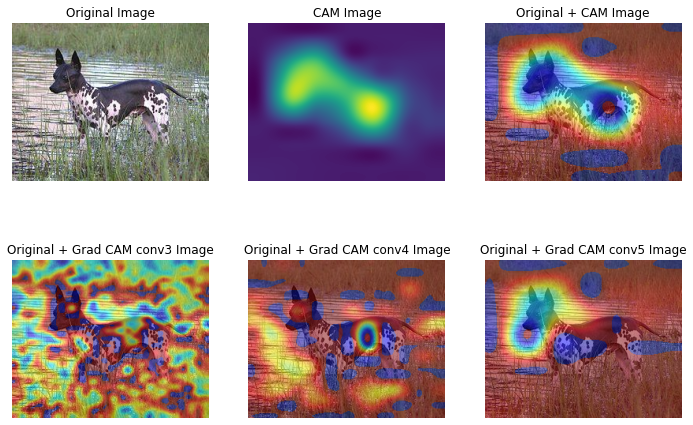

In [351]:
plt.figure(figsize=(12,8))

## 원본 이미지
plt.subplot(2,3,1)
plt.imshow(origin_image)
plt.title("Original Image")
plt.axis('off')

## CAM 이미지
plt.subplot(2,3,2)
plt.imshow(cam_image)
plt.title("CAM Image")
plt.axis('off')

## 원본 이미지 + CAM 이미지
plt.subplot(2,3,3)
plt.imshow(blended_image)
plt.title("Original + CAM Image")
plt.axis('off')

## 원본 이미지 + Grad CAM conv3
plt.subplot(2,3,4)
plt.imshow(blended_image3)
plt.title("Original + Grad CAM conv3 Image")
plt.axis('off')

## CAM 이미지 + Grad CAM conv4
plt.subplot(2,3,5)
plt.imshow(blended_image4)
plt.title("Original + Grad CAM conv4 Image")
plt.axis('off')

## 원본 이미지 + Grad CAM conv5
plt.subplot(2,3,6)
plt.imshow(blended_image5)
plt.title("Original + Grad CAM conv5 Image")
plt.axis('off')

plt.show()

**강아지 주위의 흰 부분들은 왜 생겨난걸까?**

## 3. Grad-CAM으로 얻은 CAM을 통해 bounding box 구하고 시각화하기

In [400]:
## CAM을 통해 bounding box 생성하는 함수
def get_bbox(cam_image, score_thresh=0.05):
    ## score_thresh 이하의 값들을 0으로 설정 (관심 영역 외의 값 무시)
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    
    ## CAM 이미지를 0~255 범위의 8비트 정수 형식으로 변환
    cam_image = (cam_image*255).astype(np.uint8)
    
    ## 이진화된 CAM 이미지에서 윤곽선(contours) 추출
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    ## 가장 큰 윤곽선(contours[0])을 선택하여 회전된 최소 면적 사각형 찾기
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    
    ## 최소 면적 사각형의 네 꼭짓점 좌표 추출
    rect = cv2.boxPoints(rotated_rect)
    
    ## 좌표를 정수형으로 변환하여 반환
    rect = np.int0(rect)
    return rect

In [401]:
## Original
item = get_one(ds_test)
## CAM 
cam_image = generate_cam(cam_model, item)
## Grad CAM
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

In [402]:
rect_cam = get_bbox(cam_image)
rect_grad_cam = get_bbox(grad_cam_image)

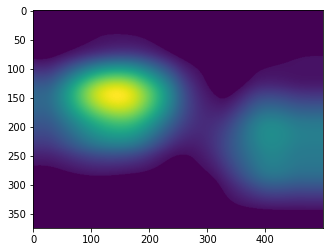

In [422]:
plt.imshow(cam_image)

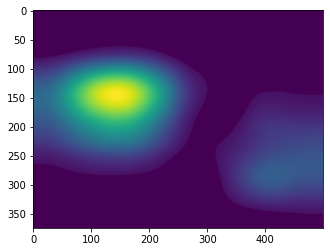

In [421]:
plt.imshow(grad_cam_image)

In [403]:
rect_cam

array([[-23, 295],
       [  6,  24],
       [527,  82],
       [497, 353]])

In [404]:
rect_grad_cam

array([[315, 140],
       [499, 140],
       [499, 350],
       [315, 350]])

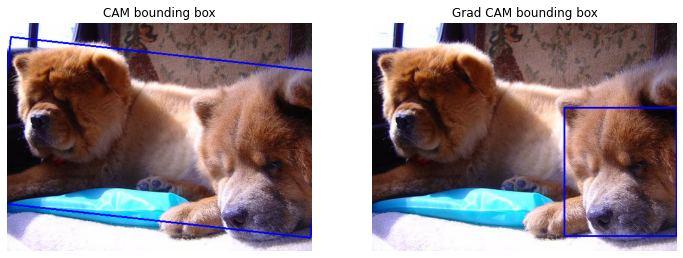

In [405]:
image_cam = copy.deepcopy(item['image'])
image_cam = cv2.drawContours(image_cam, [rect_cam], 0, (0,0,255), 2)

image_grad_cam = copy.deepcopy(item['image'])
image_grad_cam = cv2.drawContours(image_grad_cam, [rect_grad_cam], 0, (0,0,255), 2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image_cam)
plt.title("CAM bounding box")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_grad_cam)
plt.title("Grad CAM bounding box")
plt.axis('off')

plt.show()

## 4. Ground truth 와 prediction box를 이용해 IoU를 계산하는 함수 만들기

#### Ground truth의 bounding box

In [406]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

#### Prediction Box

In [407]:
## rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [408]:
pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])
pred_bbox_grad_cam = rect_to_minmax(rect_grad_cam, item['image'])

In [409]:
pred_bbox_cam

[0.064, -0.046, 0.9413333333333334, 1.054]

In [410]:
pred_bbox_grad_cam

[0.37333333333333335, 0.63, 0.9333333333333333, 0.998]

## 5. CAM 과 Grad-CAM으로 얻은 bounding box와 ground truth bounding box와의 IoU 비교하기

In [411]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    ## 교집합 영역
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    
    ## 합집합 영역
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    ## IoU 계산
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [412]:
print(f"CAM 결과의 IoU     : {get_iou(pred_bbox_cam, item['objects']['bbox'][0])}")
print(f"Grad CAM 결과의 IoU: {get_iou(pred_bbox_grad_cam, item['objects']['bbox'][0])}")

CAM 결과의 IoU     : 0.4230401839137308
Grad CAM 결과의 IoU: 0.4841195472074324


## 추가. 입력이미지로부터 바로 CAM과 Grad CAM 결과 비교

In [416]:
def check_result_random():
    ## Original
    item = get_one(ds_test)
    ## 원본 이미지를 uint8로 변환
    origin_image = item['image'].astype(np.uint8)
    
    ## CAM
    cam_image = generate_cam(cam_model, item)
    ## CAM 이미지를 3채널로 변환 및 uint8로 변환
    cam_image_3channel = np.stack([cam_image*255] * 3, axis=-1).astype(np.uint8)
    ## 원본 이미지와 CAM 이미지 합성
    blended_image = visualize_cam_on_image(origin_image, cam_image_3channel, alpha=0.5)
    
    ## conv5
    grad_cam_image5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
    ## CAM 이미지를 3채널로 변환 및 uint8로 변환
    grad_cam_image5_3channel = np.stack([grad_cam_image5*255] * 3, axis=-1).astype(np.uint8)
    ## 원본 이미지와 CAM 이미지 합성
    blended_image5 = visualize_cam_on_image(origin_image, grad_cam_image5_3channel, alpha=0.5)
    
    ## 결과 시각화
    plt.figure(figsize=(12,8))

    ## 원본 이미지
    plt.subplot(1,3,1)
    plt.imshow(origin_image)
    plt.title("Original Image")
    plt.axis('off')

    ## 원본 이미지 + CAM 이미지
    plt.subplot(1,3,2)
    plt.imshow(blended_image)
    plt.title("Original + CAM Image")
    plt.axis('off')

    ## 원본 이미지 + Grad CAM 이미지
    plt.subplot(1,3,3)
    plt.imshow(blended_image5)
    plt.title("Original + Grad CAM Image")
    plt.axis('off')

    ## bounding box     
    # 원본 이미지 크기
    image_height, image_width = item['image'].shape[:2]

    # 정규화된 좌표 (x_min, y_min, x_max, y_max) -> 픽셀 좌표로 변환
    bbox_normalized = item['objects']['bbox'][0]
    x_min_gt = int(bbox_normalized[0] * image_width)
    y_min_gt = int(bbox_normalized[1] * image_height)
    x_max_gt = int(bbox_normalized[2] * image_width)
    y_max_gt = int(bbox_normalized[3] * image_height)

    # 좌표를 사용해 Ground Truth 바운딩 박스를 정의
    rect_gt = np.array([[x_min_gt, y_min_gt], [x_max_gt, y_min_gt], [x_max_gt, y_max_gt], [x_min_gt, y_max_gt]])

    rect_cam = get_bbox(cam_image)
    rect_grad_cam = get_bbox(grad_cam_image)

    image_cam = copy.deepcopy(item['image'])
    image_cam = cv2.drawContours(image_cam, [rect_cam], 0, (0,0,255), 2)
    image_cam = cv2.drawContours(image_cam, [rect_gt], 0, (0,255,0), 2)

    image_grad_cam = copy.deepcopy(item['image'])
    image_grad_cam = cv2.drawContours(image_grad_cam, [rect_grad_cam], 0, (0,0,255), 2)
    image_grad_cam = cv2.drawContours(image_grad_cam, [rect_gt], 0, (0,255,0), 2)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(image_cam)
    plt.title("CAM bounding box")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(image_grad_cam)
    plt.title("Grad CAM bounding box")
    plt.axis('off')

    plt.show()
    
    ## IoU
    pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])
    pred_bbox_grad_cam = rect_to_minmax(rect_grad_cam, item['image'])
    
    print(f"CAM 결과의 IoU     : {get_iou(pred_bbox_cam, item['objects']['bbox'][0])}")
    print(f"Grad CAM 결과의 IoU: {get_iou(pred_bbox_grad_cam, item['objects']['bbox'][0])}")

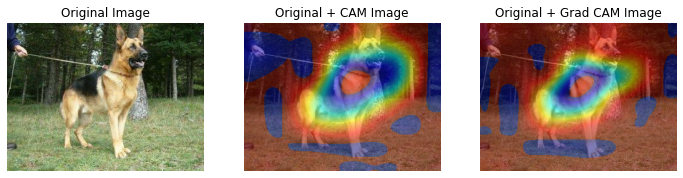

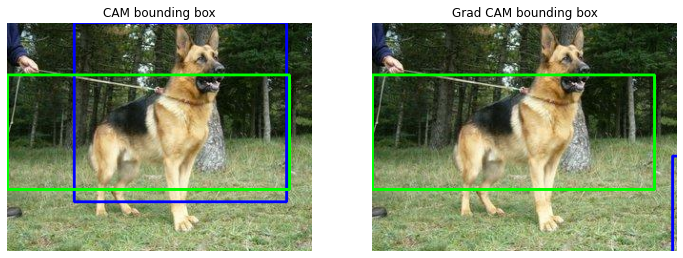

CAM 결과의 IoU     : 0.6350814903572917
Grad CAM 결과의 IoU: 0.0


In [417]:
check_result_random()

## 회고
Grad CAM에서의 IoU가 대부분 더 낮게 나왔다.   
bounding box가 더 작게 나와서 그런 것 같다.  


Grad CAM의 bbox결과가 이상하여 에러를 계속해서 고치고 있다.  
끝나고 나서 코드를 조금 더 자세히 살펴보고 해결해야겠다.  